# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [22]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score,
                             average_precision_score)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1
...,...,...,...,...
1195,1884.390748,33.585137,14.422719,0
1196,395.783715,26.987242,21.847596,0
1197,480.224675,49.941911,9.715692,0
1198,750.018210,26.579564,17.101275,0


## 1) Train/Test Split

In [3]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values # Includes CAPE, PWAT, and shear
X_reduced = df[FEATURES_REDUCED].values # Only includes CAPE
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, 
                                                        y, 
                                                        test_size=0.25, 
                                                        random_state=0, 
                                                        stratify=y) # Full

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, 
                                                        y, 
                                                        test_size=0.25, 
                                                        random_state=0, 
                                                        stratify=y) # Reduced

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [ ]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

# Predict probs on test sets (use for ROC and PR curves)
yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [ ]:
thr = 0.5 # 0.5 is 50% percent probability
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5
acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full, zero_division=0)
rec_full = recall_score(yf_test, ypred_full, zero_division=0)

print(f"-Full-\nAccuracy:  {acc_full:.3f}\nPrecision: {prec_full:.3f}\nRecall: {rec_full:.3f}")

acc_red = accuracy_score(yr_test, ypred_reduced)
prec_red = precision_score(yr_test, ypred_reduced, zero_division=0)
rec_red = recall_score(yr_test, ypred_reduced, zero_division=0)

print(f"\n-Reduced-\nAccuracy:  {acc_red:.3f}\nPrecision: {prec_red:.3f}\nRecall: {rec_red:.3f}")

-Full-
Accuracy:  0.723
Precision: 0.733
Recall: 0.678

-Reduced-
Accuracy:  0.717
Precision: 0.736
Recall: 0.651


## 4) Plot ROC and Precision–Recall Curves

/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/global/homes/d/dbrooks/.conda/envs/myenv/lib/python3.11/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


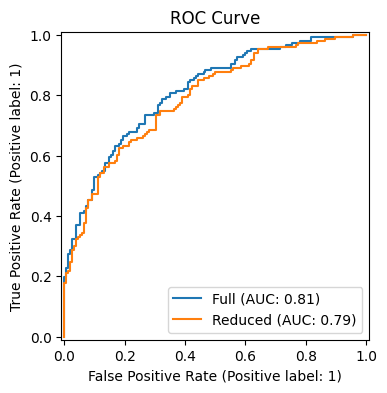

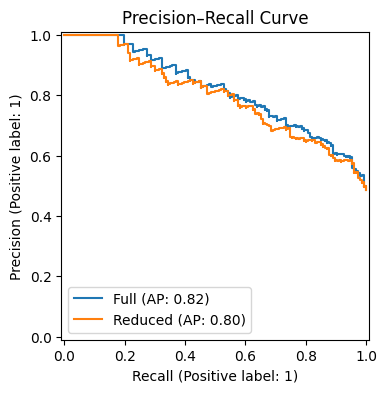

In [24]:
# TODO: Plot ROC and PR curves for both models on shared axes

# ROC
fig, ax = plt.subplots(1,1, figsize=(4,4))
auc_full = roc_auc_score(yf_test,yprob_full) # Area under ROC curve (AUC)
auc_red = roc_auc_score(yr_test,yprob_reduced)
RocCurveDisplay.from_predictions(yf_test, yprob_full, ax=ax, label=f'Full (AUC: {auc_full:.2f})')
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, ax=ax, label=f'Reduced (AUC: {auc_red:.2f})')
ax.set_title("ROC Curve")
plt.show()

# PR
fig, ax = plt.subplots(1,1, figsize=(4,4))
ap_full = average_precision_score(yf_test,yprob_full) # AP score (= to AUC for PR curve)
ap_red = average_precision_score(yr_test,yprob_reduced)
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, ax=ax, label=f'Full (AP: {ap_full:.2f})')
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, ax=ax, label=f'Reduced (AP: {ap_red:.2f})')
ax.set_title("Precision–Recall Curve")
plt.show()

## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

1. The full, 3 variable model has a slightly higher ROC-AUC and PR-AUC but not by much. This would imply that including PWAT in the model, while providing a slight improvement, does not significantly alter its performance in predicting convective storms.

2. To maximize event detection, I would choose the full model as it has a slightly higher recall value. If I want to minimize false alarms, I would choose the reduced model as its precision value is ever so slightly higher.